In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.constants import hbar_meV_ps as hbar, e as e_charge, me as m_electron, mt as m_eff

tf.keras.backend.set_floatx('float64')

In [3]:
Lx = 50
Lz = 50
T = 1

qd_x_start = 15
qd_x_end = 25
v_qd = (qd_x_end - qd_x_start) / T

Ez = 5e-3

omega = 2 / hbar

hbar_c = tf.cast(hbar, tf.complex128)
e_charge_c = tf.cast(e_charge, tf.complex128)
m_electron_c = tf.cast(m_electron, tf.complex128)
m_eff_c = tf.cast(m_eff, tf.complex128)

W0000 00:00:1733176509.717969   12495 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
def potnetial_function(x, z, t):
  x_qd = qd_x_start + v_qd * t

  V_qd = 0.5 * m_eff * omega**2 * (x - x_qd)**2
  V_electric = - e_charge * Ez * z

  V_total = V_qd + V_electric

  return V_total

In [5]:
class PINN(tf.keras.Model):
  def __init__(self, layers):
    super(PINN, self).__init__()
    self.hidden_layers = [tf.keras.layers.Dense(units, activation='tanh', dtype='float64') for units in layers[:-1]]
    self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None, dtype='float64')

  def call(self, inputs):
    x, z, t = inputs
    X = tf.stack([x, z, t], axis=1)
    
    for layer in self.hidden_layers:
        X = layer(X)

    output = self.output_layer(X)
    psi_real = output[:, 0:1]
    psi_imag = output[:, 1:2]
    return psi_real, psi_imag

In [6]:
layers = [3, 50, 50, 50, 50, 2]

In [7]:
n_collocation = 10000
n_initial = 2000
n_boundary = 1000

x_min, x_max = 0, Lx
z_min, z_max = 0, Lz
t_min, t_max = 0, T

x_collocation = np.random.uniform(x_min, x_max, n_collocation)
z_collocation = np.random.uniform(z_min, z_max, n_collocation)
t_collocation = np.random.uniform(t_min, t_max, n_collocation)

x_initial = np.random.uniform(x_min, x_max, n_initial)
z_initial = np.random.uniform(z_min, z_max, n_initial)
t_initial = np.full(n_initial, t_min)

x_boundary_x = np.concatenate([np.full(n_boundary // 2, x_min), np.full(n_boundary // 2, x_max)])
z_boundary_x = np.random.uniform(z_min, z_max, n_boundary)
t_boundary_y = np.random.uniform(t_min, t_max, n_boundary)

x_boundary_z = np.random.uniform(x_min, x_max, n_boundary)
z_boundary_z = np.concatenate([np.full(n_boundary // 2, z_min), np.full(n_boundary // 2, z_max)])
t_boundary_z = np.random.uniform(t_min, t_max, n_boundary)

x_boundary_total = np.concatenate([x_boundary_x, x_boundary_z])
z_boundary_total = np.concatenate([z_boundary_x, z_boundary_z])
t_boundary_total = np.concatenate([t_boundary_y, t_boundary_z])

In [8]:
x_collocation_tf = tf.convert_to_tensor(x_collocation, dtype=tf.float64)
z_collocation_tf = tf.convert_to_tensor(z_collocation, dtype=tf.float64)
t_collocation_tf = tf.convert_to_tensor(t_collocation, dtype=tf.float64)

x_initial_tf = tf.convert_to_tensor(x_initial, dtype=tf.float64)
z_initial_tf = tf.convert_to_tensor(z_initial, dtype=tf.float64)
t_initial_tf = tf.convert_to_tensor(t_initial, dtype=tf.float64)

x_boundary_tf = tf.convert_to_tensor(x_boundary_total, dtype=tf.float64)
z_boundary_tf = tf.convert_to_tensor(z_boundary_total, dtype=tf.float64)
t_boundary_tf = tf.convert_to_tensor(t_boundary_total, dtype=tf.float64)

In [9]:
# Normalization of the input data to [-1, 1]
def normalize(x, x_min, x_max):
  return 2.0 * (x - x_min) / (x_max - x_min) - 1.0

In [10]:
x_collocation_norm = normalize(x_collocation_tf, x_min, x_max)
z_collocation_norm = normalize(z_collocation_tf, z_min, z_max)
t_collocation_norm = normalize(t_collocation_tf, t_min, t_max)

x_initial_norm = normalize(x_initial_tf, x_min, x_max)
z_initial_norm = normalize(z_initial_tf, z_min, z_max)
t_initial_norm = normalize(t_initial_tf, t_min, t_max)

x_boundary_norm = normalize(x_boundary_tf, x_min, x_max)
z_boundary_norm = normalize(z_boundary_tf, z_min, z_max)
t_boundary_norm = normalize(t_boundary_tf, t_min, t_max)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [12]:
model = PINN(layers)

In [13]:
@tf.function
def loss_function():
  #physics loss
  with tf.GradientTape(persistent=True) as tape1:
    tape1.watch([x_collocation_tf, z_collocation_tf, t_collocation_tf])

    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x_collocation_tf, z_collocation_tf, t_collocation_tf])
      psi_real, psi_img = model((x_collocation_tf, z_collocation_tf, t_collocation_tf))
      psi = tf.complex(psi_real, psi_img)

    d_psi_dx = tape2.gradient(psi, x_collocation_tf)
    d_psi_dz = tape2.gradient(psi, z_collocation_tf)
    d_psi_dt = tape2.gradient(psi, t_collocation_tf)

  d2_psi_dx2 = tape1.gradient(d_psi_dx, x_collocation_tf)
  d2_psi_dz2 = tape1.gradient(d_psi_dz, z_collocation_tf)

  V = potnetial_function(x_collocation_tf, z_collocation_tf, t_collocation_tf)
  V = tf.cast(V, dtype=tf.complex128)

  i = tf.complex(0.0, 1.0)
  i = tf.cast(i, tf.complex128)
  d_psi_dt = tf.cast(d_psi_dt, tf.complex128)
  d2_psi_dx2 = tf.cast(d2_psi_dx2, tf.complex128)
  d2_psi_dz2 = tf.cast(d2_psi_dz2, tf.complex128)
  residual = (i * hbar_c * d_psi_dt + ((hbar_c ** 2) / (2 * m_eff_c)) * (d2_psi_dx2 + d2_psi_dz2) - V * psi)
  physics_loss = tf.reduce_mean(tf.square(tf.abs(residual)))


  #initial condition loss
  psi_real_initial, psi_img_initial = model((x_initial_tf, z_initial_tf, t_initial_tf))
  psi_initial = tf.complex(psi_real_initial, psi_img_initial)

  sigma = 5
  psi_ig = tf.exp(-((x_initial_tf - qd_x_start) ** 2 + (z_initial_tf - Lz / 2) **2 ) / (2 * sigma ** 2))
  psi_ig = tf.cast(psi_ig, dtype=tf.complex128)

  initial_condition_loss = tf.reduce_mean(tf.square(tf.abs(psi_initial - psi_ig)))


  #boundary condition loss
  psi_real_boundary, psi_img_boundary = model((x_boundary_tf, z_boundary_tf, t_boundary_tf))
  psi_boundary = tf.complex(psi_real_boundary, psi_img_boundary)
  boundary_condition_loss = tf.reduce_mean(tf.square(tf.abs(psi_boundary)))


  #normalization loss
  # psi_real_n, psi_img_n = model((x_collocation_tf, z_collocation_tf, t_collocation_tf))
  # psi_n = tf.complex(psi_real_n, psi_img_n)

  # prob_density = tf.square(tf.abs(psi_n))
  # normalization_factor = tf.reduce_mean(prob_density) * (x_max - x_min) * (z_max - z_min)
  # normalization_loss = tf.reduce_mean(tf.square(normalization_factor - 1))
  normalization_loss = 0

  total_loss = physics_loss + initial_condition_loss + boundary_condition_loss + normalization_loss
  return total_loss, physics_loss, initial_condition_loss, boundary_condition_loss, normalization_loss

In [14]:
epochs = 300
history = []

for epoch in range(1, epochs+1):
    with tf.GradientTape() as tape:
        total_loss, physics_loss, initial_condition_loss, boundary_condition_loss, normalization_loss = loss_function()

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    history.append({
        'total_loss': total_loss.numpy(),
        'physics_loss': physics_loss.numpy(),
        'initial_condition_loss': initial_condition_loss.numpy(),
        'boundary_condition_loss': boundary_condition_loss.numpy(),
        'normalization_loss': normalization_loss.numpy()
    })
    print(f"Epoch {epoch}/{epochs}\nTotal Loss: {total_loss.numpy()}\nPhysics Loss: {physics_loss.numpy()}\nInitial Condition Loss: {initial_condition_loss.numpy()}\nBoundary Condition Loss: {boundary_condition_loss.numpy()}\nNormalization Loss: {normalization_loss.numpy()}")
    print("--------------------------------------------------")

2024-12-01 11:34:01.765401: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1600000000 exceeds 10% of free system memory.
2024-12-01 11:34:03.341810: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1600000000 exceeds 10% of free system memory.
2024-12-01 11:34:04.078716: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1600000000 exceeds 10% of free system memory.
2024-12-01 11:34:04.969787: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1600000000 exceeds 10% of free system memory.
2024-12-01 11:34:05.824814: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1600000000 exceeds 10% of free system memory.


Epoch 1/300
Total Loss: 6359.073472382655
Physics Loss: 6358.402518007373
Initial Condition Loss: 0.3862971405826713
Boundary Condition Loss: 0.28465723469941173
Normalization Loss: 0
--------------------------------------------------
Epoch 2/300
Total Loss: 2428.380984194267
Physics Loss: 2428.096383636673
Initial Condition Loss: 0.17429769010435045
Boundary Condition Loss: 0.11030286748959063
Normalization Loss: 0
--------------------------------------------------
Epoch 3/300
Total Loss: 560.4884919401037
Physics Loss: 560.3970751821263
Initial Condition Loss: 0.06403299764107348
Boundary Condition Loss: 0.027383760336288688
Normalization Loss: 0
--------------------------------------------------
Epoch 4/300
Total Loss: 292.15065446961034
Physics Loss: 292.1002319414467
Initial Condition Loss: 0.03510664902181423
Boundary Condition Loss: 0.015315879141830333
Normalization Loss: 0
--------------------------------------------------
Epoch 5/300
Total Loss: 760.3988098162118
Physics Loss

In [15]:
# Extract loss values from history
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]
normalization_loss_history = [record['normalization_loss'] for record in history]

# Create an array of epoch numbers
epochs_range = range(1, epochs + 1)

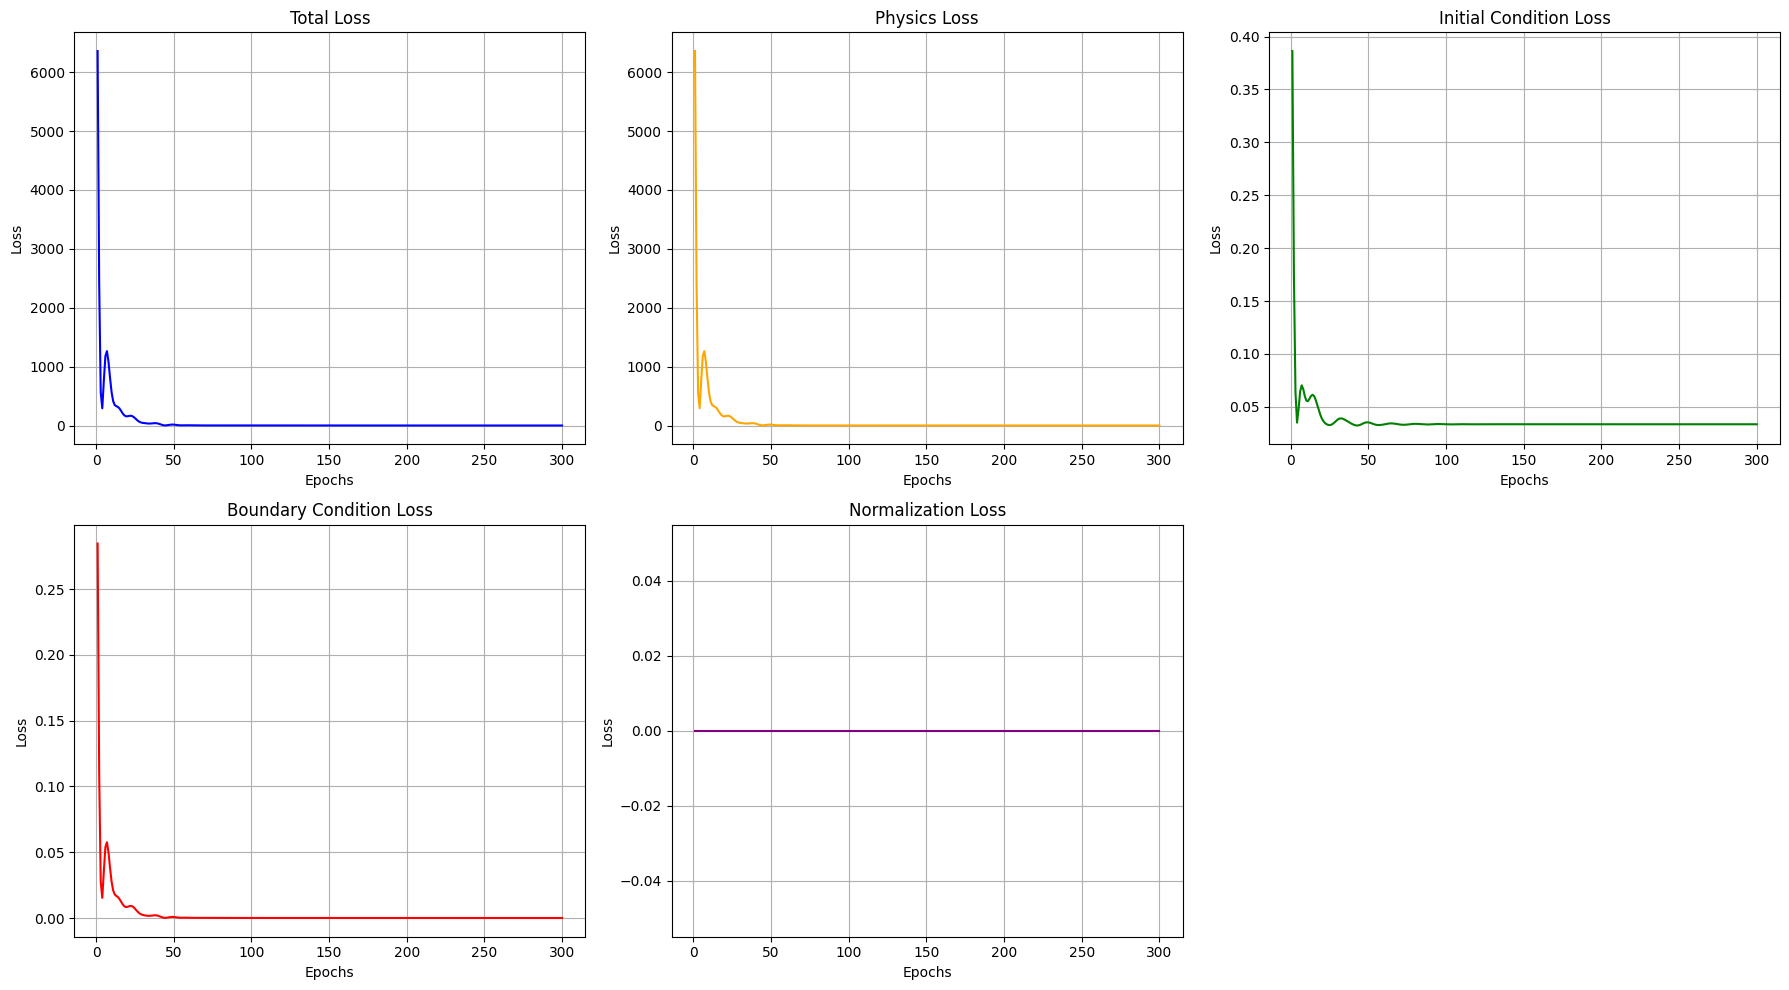

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)

# Initial Condition Loss
axs[0, 2].plot(epochs_range, initial_condition_loss_history, color='green')
axs[0, 2].set_title('Initial Condition Loss')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].grid(True)

# Boundary Condition Loss
axs[1, 0].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 0].set_title('Boundary Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)

# Normalization Loss
axs[1, 1].plot(epochs_range, normalization_loss_history, color='purple')
axs[1, 1].set_title('Normalization Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)

# Hide the empty subplot (since we have 5 plots)
axs[1, 2].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

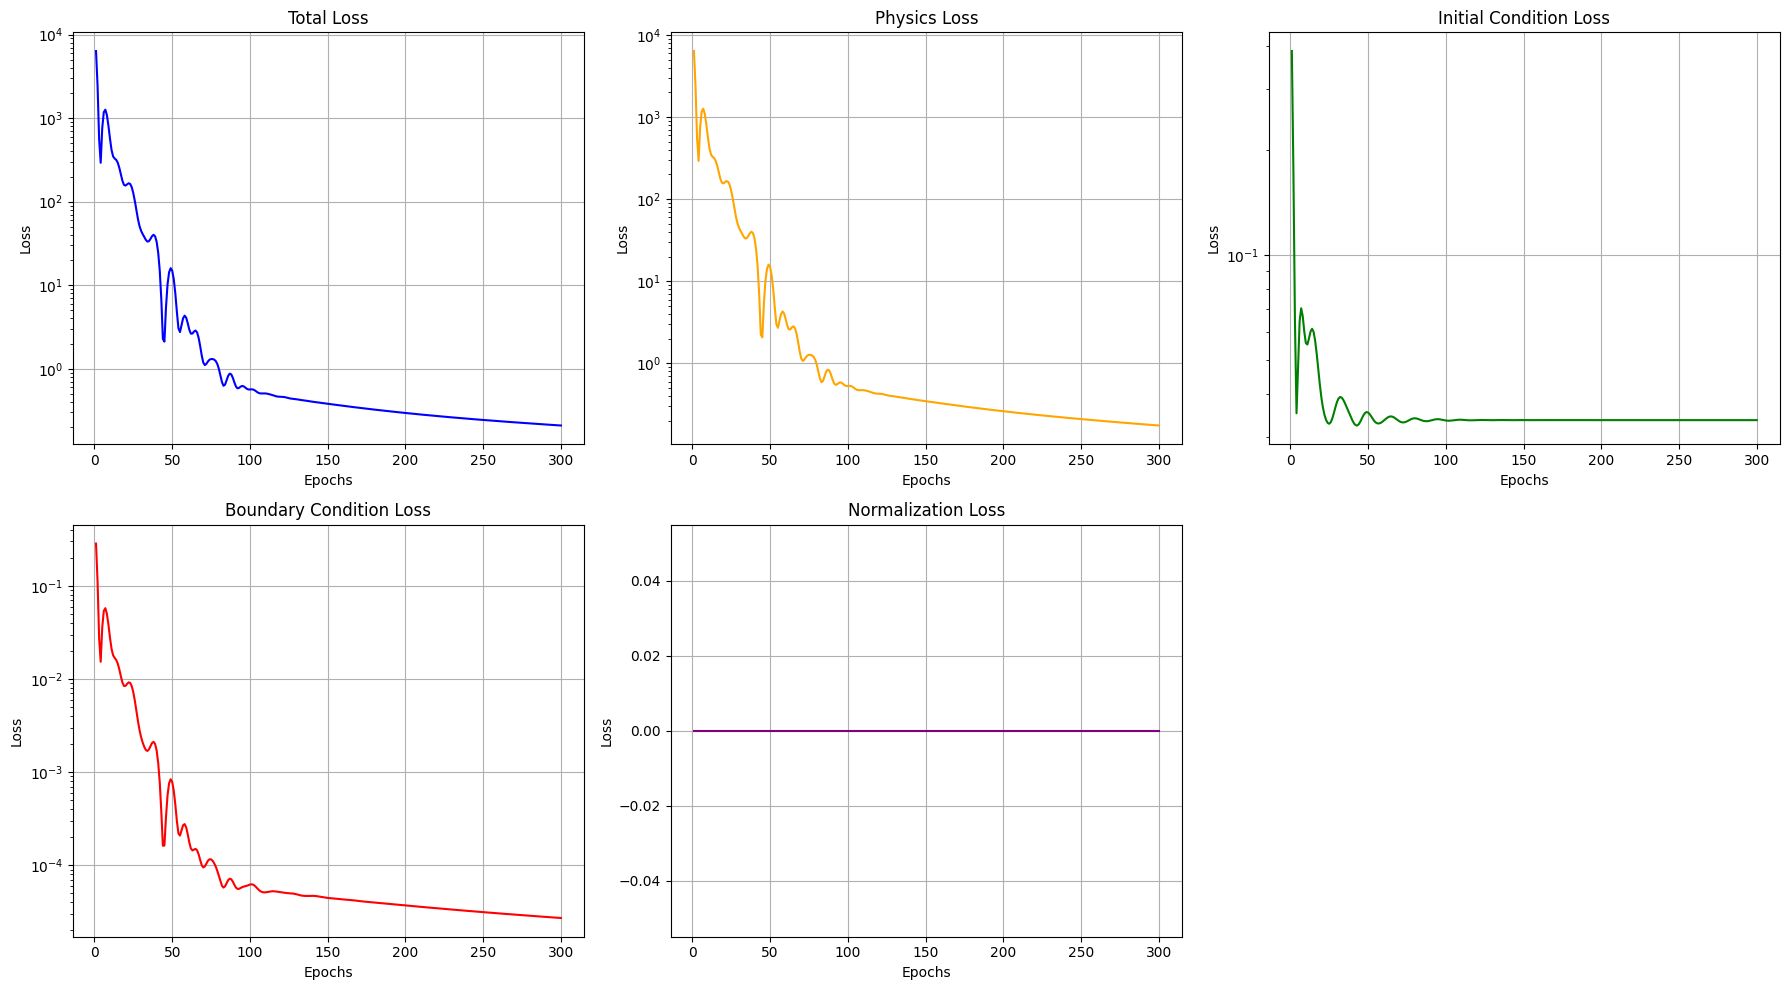

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale('log')  # Set y-axis to logarithmic scale

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale('log')  # Set y-axis to logarithmic scale

# Initial Condition Loss
axs[0, 2].plot(epochs_range, initial_condition_loss_history, color='green')
axs[0, 2].set_title('Initial Condition Loss')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].grid(True)
axs[0, 2].set_yscale('log')  # Set y-axis to logarithmic scale

# Boundary Condition Loss
axs[1, 0].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 0].set_title('Boundary Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale('log')  # Set y-axis to logarithmic scale

# Normalization Loss
axs[1, 1].plot(epochs_range, normalization_loss_history, color='purple')
axs[1, 1].set_title('Normalization Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
# axs[1, 1].set_yscale('log')  # Set y-axis to logarithmic scale

# Hide the empty subplot (since we have 5 plots)
axs[1, 2].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


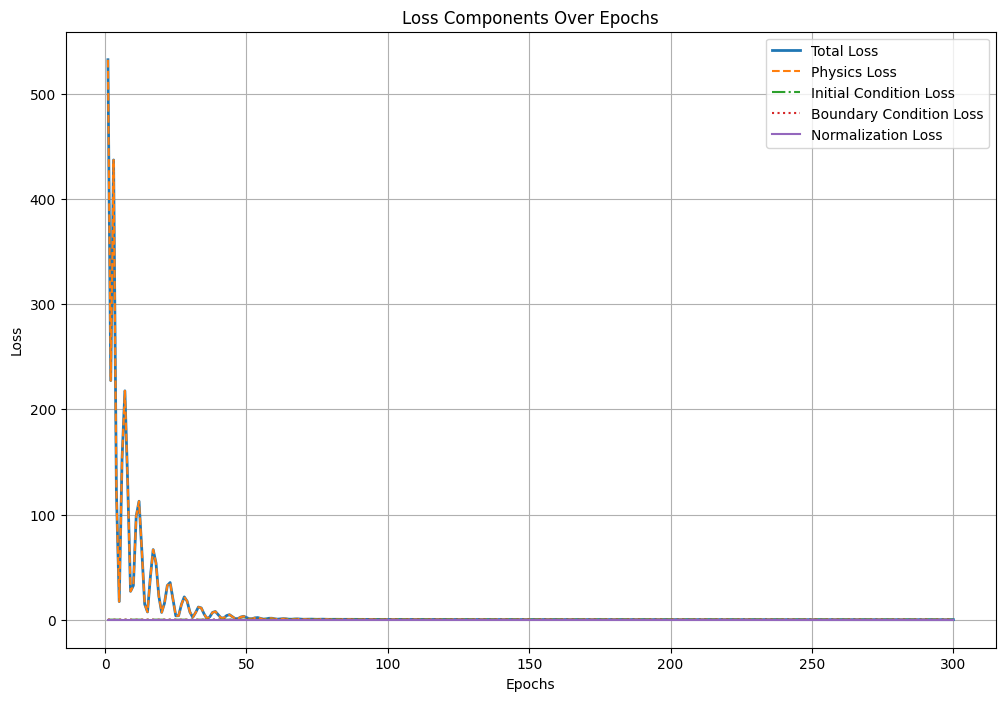

In [16]:
plt.figure(figsize=(12, 8))

# Plot total loss
plt.plot(epochs_range, total_loss_history, label='Total Loss', linewidth=2)

# Plot individual losses
plt.plot(epochs_range, physics_loss_history, label='Physics Loss', linestyle='--')
plt.plot(epochs_range, initial_condition_loss_history, label='Initial Condition Loss', linestyle='-.')
plt.plot(epochs_range, boundary_condition_loss_history, label='Boundary Condition Loss', linestyle=':')
plt.plot(epochs_range, normalization_loss_history, label='Normalization Loss', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Components Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x = 2.9632197
x = 2
while x ** x != 25:
  
x ** x

24.999996093788983